# Malaria Diagnosis With CNN

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer,Conv2D, MaxPool2D, Dense, Flatten,BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer

# Loading The Dataset

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True,shuffle_files=True,split=['train'])


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteUUFMAT/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
for data in dataset[0].take(1):
  print(data)
  break

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [4]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

# Data Visualization

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

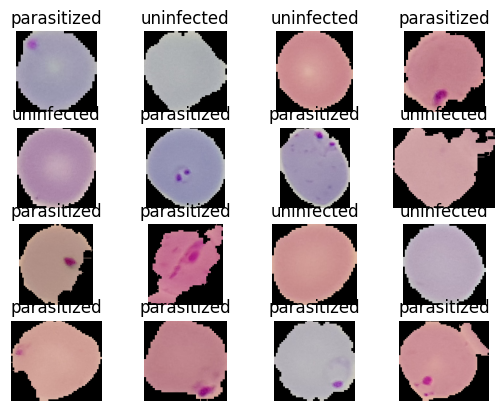

In [6]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Data Preprocessing

In [7]:
dataset_info.features['label'].int2str(0)

'parasitized'

In [8]:
IM_SIZE=224
def resize_rescale(image, label):

  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255, label

In [9]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)



In [10]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [11]:
train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
val_dataset = val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)


In [13]:
test_dataset = test_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)


# Model Creation

In [14]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6,kernel_size=3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides=2),


    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides=2),

    Flatten(),

    Dense(128, activation="relu"),
    BatchNormalization(),

    Dense( 10, activation="relu"),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [15]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0227046>

In [16]:

lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics='accuracy')

In [17]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Model Training

In [ ]:
history=lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)

Epoch 1/20
689/689 [==============================] - 62s 68ms/step - loss: 0.2795 - accuracy: 0.8946 - val_loss: 0.4915 - val_accuracy: 0.6356
Epoch 2/20
689/689 [==============================] - 43s 63ms/step - loss: 0.1904 - accuracy: 0.9365 - val_loss: 0.2255 - val_accuracy: 0.9274
Epoch 3/20
689/689 [==============================] - 49s 72ms/step - loss: 0.1645 - accuracy: 0.9454 - val_loss: 0.5407 - val_accuracy: 0.8737
Epoch 4/20
689/689 [==============================] - 41s 60ms/step - loss: 0.1630 - accuracy: 0.9445 - val_loss: 0.2451 - val_accuracy: 0.9303
Epoch 5/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1347 - accuracy: 0.9563 - val_loss: 0.2134 - val_accuracy: 0.9412
Epoch 6/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1245 - accuracy: 0.9581 - val_loss: 0.2682 - val_accuracy: 0.9289
Epoch 7/20
689/689 [==============================] - 49s 71ms/step - loss: 0.1111 - accuracy: 0.9637 - val_loss: 0.2280 - val_accuracy:

# Model Visualization

<Axes: >

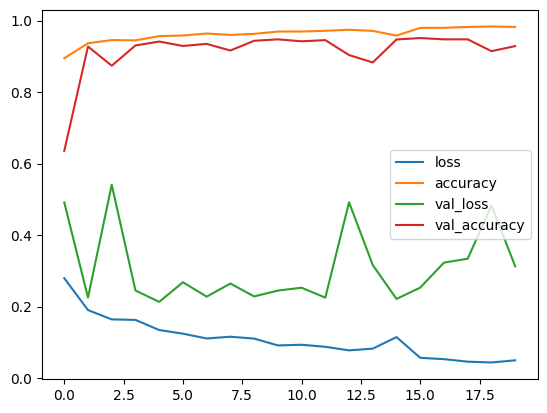

In [ ]:
import pandas as pd
losses = pd.DataFrame(history.history)
losses.plot()

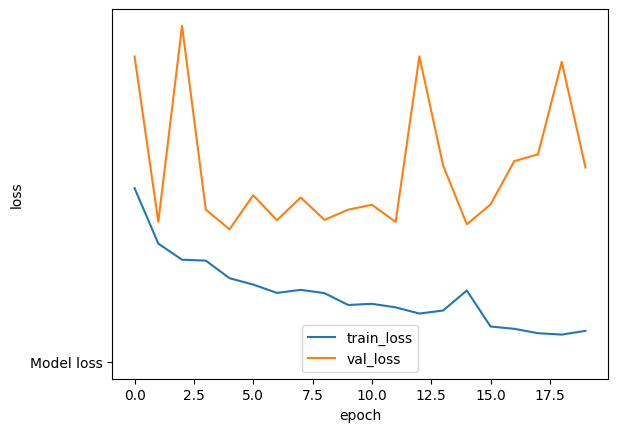

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

# Saving and Loading Model

In [ ]:
from tensorflow.keras.models import load_model
lenet_model.save('malaria.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = load_model('malaria.h5')
loaded_model.evaluate(test_dataset)

87/87 [==============================] - 14s 45ms/step - loss: 0.3322 - accuracy: 0.9206


[0.33215922117233276, 0.9205658435821533]

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Model Evaluation

In [ ]:
lenet_model.evaluate(test_dataset)

87/87 [==============================] - 14s 33ms/step - loss: 0.3333 - accuracy: 0.9209


[0.3332870900630951, 0.9209285378456116]

In [ ]:
def parasite_or_not(x):
  if (x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'P'

1/1 [==============================] - 0s 29ms/step


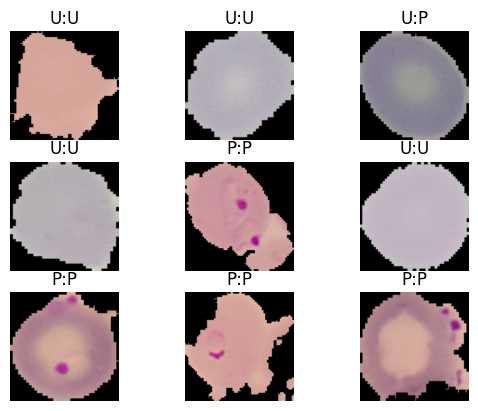

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":"+ str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')

# Functional API

In [19]:
func_input = Input(shape=(IM_SIZE,IM_SIZE,3),name="InputImage")

x=Conv2D(filters=6,kernel_size=3, strides=1, padding='valid',
          activation = 'relu')(func_input)
x=BatchNormalization()(x)
x=MaxPool2D (pool_size=2, strides=2)(x)


x=Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
          activation = 'relu')(x)
x=BatchNormalization()(x)
output=MaxPool2D (pool_size=2, strides=2)(x)


feature_extractor_model = Model(func_input, output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputImage (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_3 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_4 (Bat  (None, 109, 109, 16)

In [21]:
func_input = Input(shape=(IM_SIZE,IM_SIZE,3))

x = feature_extractor_model(func_input)
x=Flatten()(x)

x=Dense(128, activation="relu")(x)
x=BatchNormalization()(x)

x=Dense( 10, activation="relu")(x)
x=BatchNormalization()(x)

func_output=Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               5972096   
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 10)                

In [24]:

lenet_model_func.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics='accuracy')

In [25]:
history=lenet_model_func.fit(train_dataset,validation_data=val_dataset,epochs=10,verbose=1)

Epoch 1/10
689/689 [==============================] - 74s 87ms/step - loss: 0.4106 - accuracy: 0.8076 - val_loss: 5.7492 - val_accuracy: 0.5978
Epoch 2/10
689/689 [==============================] - 42s 60ms/step - loss: 0.2034 - accuracy: 0.9329 - val_loss: 0.2029 - val_accuracy: 0.9477
Epoch 3/10
689/689 [==============================] - 43s 62ms/step - loss: 0.1864 - accuracy: 0.9417 - val_loss: 0.2143 - val_accuracy: 0.9314
Epoch 4/10
689/689 [==============================] - 46s 67ms/step - loss: 0.1659 - accuracy: 0.9469 - val_loss: 0.1708 - val_accuracy: 0.9448
Epoch 5/10
689/689 [==============================] - 51s 74ms/step - loss: 0.1540 - accuracy: 0.9514 - val_loss: 0.1746 - val_accuracy: 0.9521
Epoch 6/10
689/689 [==============================] - 44s 64ms/step - loss: 0.1447 - accuracy: 0.9533 - val_loss: 0.1624 - val_accuracy: 0.9492
Epoch 7/10
689/689 [==============================] - 42s 61ms/step - loss: 0.1584 - accuracy: 0.9483 - val_loss: 0.2583 - val_accuracy:

# Callable Model

In [26]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6,kernel_size=3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides=2),


    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides=2),

])

feature_extractor_seq_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_11 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_12 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [27]:
func_input = Input(shape=(IM_SIZE,IM_SIZE,3))

x = feature_extractor_seq_model(func_input)
x=Flatten()(x)

x=Dense(128, activation="relu")(x)
x=BatchNormalization()(x)

x=Dense( 10, activation="relu")(x)
x=BatchNormalization()(x)

func_output=Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               5972096   
                                                                 
 batch_normalization_13 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 10)                1290      
                                                       

# Model Subclassing

In [31]:
class FeatureExtractor(Layer):
  def __init__(self,filters, kernel_size,strides,padding,activation,pool_size):
    super(FeatureExtractor, self).__init__()
    self.conv_1 = Conv2D(filters=filters,kernel_size=kernel_size, strides=strides,padding=padding,activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=filters,kernel_size=kernel_size, strides=strides,padding=padding,activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)


    def call(self,x,training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x
feature_subclass = FeatureExtractor(8, 3,1,'valid','relu',2)

In [32]:
func_input = Input(shape=(IM_SIZE,IM_SIZE,3))

x = feature_subclass(func_input)
x=Flatten()(x)

x=Dense(128, activation="relu")(x)
x=BatchNormalization()(x)

x=Dense( 10, activation="relu")(x)
x=BatchNormalization()(x)

func_output=Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 224, 224, 3)       0         
 Extractor)                                                      
                                                                 
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 dense_12 (Dense)            (None, 128)               19267712  
                                                                 
 batch_normalization_17 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 10)                

# Custom Layers

In [63]:

class NeuralLayer(Layer):
  def __init__(self, output_units, activation):
    super(NeuralLayer, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape=(input_features_shape[-1], self.output_units), initializer="random_normal", trainable=True)
    self.b = self.add_weight(shape=(self.output_units,), initializer="random_normal", trainable=True)

  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if self.activation == 'relu':
      return tf.nn.relu(pre_output)
    elif self.activation == 'sigmoid':
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [64]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6,kernel_size=3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides=2),


    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',
          activation = 'relu'),
    BatchNormalization(),
    MaxPool2D (pool_size=2, strides=2),

    Flatten(),

    NeuralLayer(128, activation="relu"),
    BatchNormalization(),

    NeuralLayer( 10, activation="relu"),

    NeuralLayer(1, activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_39 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_40 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      